# Study the Data

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Ruta a tu archivo generado (Ajusta si cambiaste la carpeta)
FILE_PATH = "../data/raw/wiki_dump.jsonl"

data = []
print(f"📂 Loading data from {FILE_PATH}...")

# Leemos línea por línea para evitar errores de memoria si el archivo es gigante
with open(FILE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(data)

print(f"✅ Data Loaded. Shape: {df.shape}")
df.head()

📂 Loading data from ../data/raw/wiki_dump.jsonl...
✅ Data Loaded. Shape: (5483, 5)


,id,title,url,content,infobox
0,17333,A.J. Kennedy,https://gameofthrones.fandom.com/wiki/?curid=1...,A.J. Kennedy is an actor who portrayed a Frey ...,{}
1,2713,A Golden Crown,https://gameofthrones.fandom.com/wiki/?curid=2713,"""A Golden Crown"" is the sixth episode of the f...","{'Type': 'Thrones', 'Image': 'GOT106.jpg', 'Se..."
2,17755,A Golden Crown/Appearances,https://gameofthrones.fandom.com/wiki/?curid=1...,"A list of individuals, institutions, locations...",{}
3,79113,A Golden Crown (short),https://gameofthrones.fandom.com/wiki/?curid=7...,"""A Golden Crown"" is the sixth short of the fir...",{}
4,68592,A Knight of the Seven Kingdoms,https://gameofthrones.fandom.com/wiki/?curid=6...,A Knight of the Seven Kingdoms is the upcoming...,{}


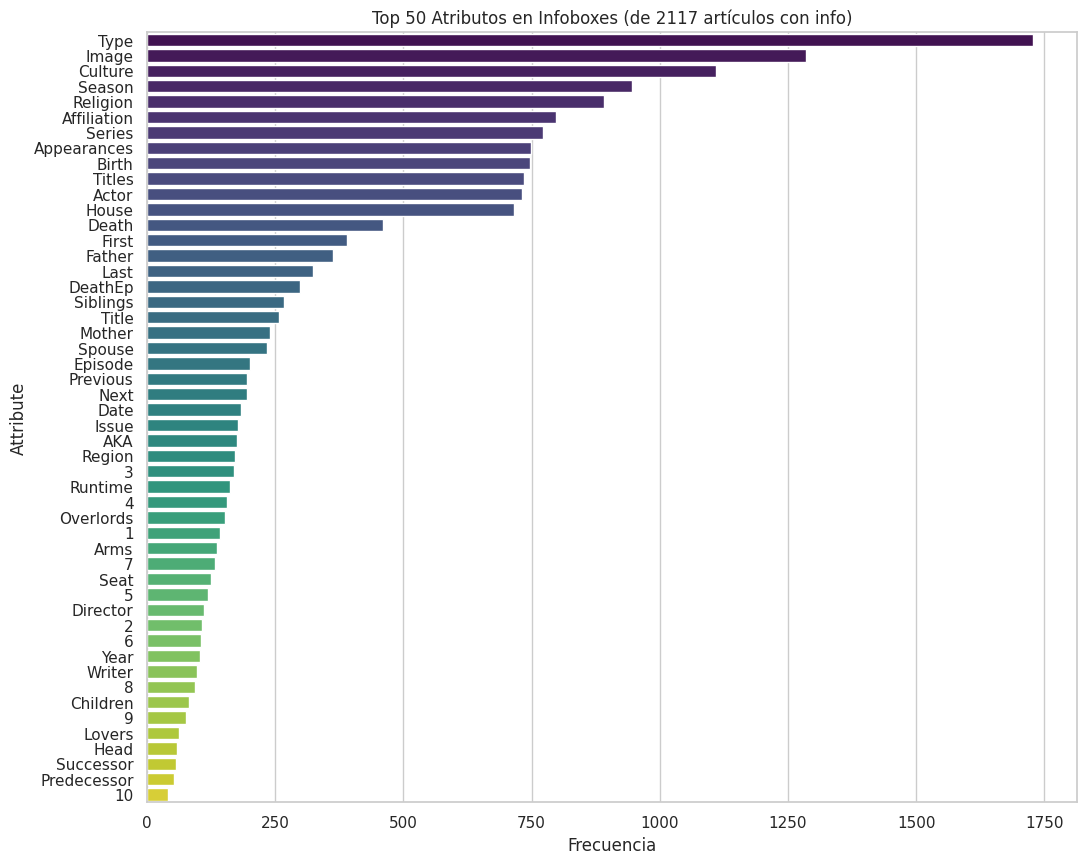

💡 INSIGHT: Las claves más comunes (ej: 'House', 'Allegiance', 'Father') deberían ser tus Relaciones (Edges) en el Grafo.


In [11]:
# 1. Aplanar los infoboxes para ver qué claves son comunes
# Queremos saber: ¿Todos los personajes tienen 'House'? ¿Tienen 'Father'?
all_keys = []
total_infoboxes = 0

for info in df['infobox']:
    if info:
        total_infoboxes += 1
        all_keys.extend(info.keys())

key_counts = Counter(all_keys)
common_keys_df = pd.DataFrame(key_counts.most_common(50), columns=['Attribute', 'Count'])

# Visualización
plt.figure(figsize=(12, 10))
sns.barplot(data=common_keys_df, x='Count', y='Attribute', palette="viridis", hue='Attribute')
plt.title(f"Top 50 Atributos en Infoboxes (de {total_infoboxes} artículos con info)")
plt.xlabel("Frecuencia")
plt.show()

print("💡 INSIGHT: Las claves más comunes (ej: 'House', 'Allegiance', 'Father') deberían ser tus Relaciones (Edges) en el Grafo.")

In [ ]:
import json
import re
import os
from collections import Counter, defaultdict

INPUT_FILE = "../data/raw/wiki_dump.jsonl" # Ajusta si tu ruta es distinta
OUTPUT_JSON = "../data/raw/wiki_attribute_analysis.json"

# Atributos que sabemos que son "ruido" visual y no datos semánticos
BLACKLIST_ATTRIBUTES = {
    "image", "caption", "alt", "imagesize", "bg", "align", 
    "width", "file", "image_size", "bgcolor"
}

def clean_wiki_value(text):
    """
    Limpia artefactos comunes de MediaWiki para el análisis.
    Ej: '[[House Stark|Stark]]' -> 'Stark'
    """
    if not isinstance(text, str):
        return str(text)
    
    # 1. Eliminar enlaces wiki: [[Texto|Visible]] -> Visible, o [[Texto]] -> Texto
    # Regex explica: Busca [[, opcionalmente algo seguido de |, captura lo que sigue, cierra ]]
    text = re.sub(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', r'\1', text)
    
    # 2. Eliminar tags HTML simples (<br>, <small>)
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # 3. Eliminar parentesis de desambiguación si se desea (opcional)
    # text = re.sub(r'\s*\(.*?\)', '', text)
    
    return text.strip()

def generate_attribute_report():
    print(f"📂 Leyendo {INPUT_FILE}...")
    
    # Estructura para guardar todos los valores crudos por atributo
    # attribute_values["House"] = ["Stark", "Lannister", "Stark", ...]
    attribute_values = defaultdict(list)
    total_articles = 0
    
    # 1. LECTURA Y EXTRACCIÓN
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                article = json.loads(line)
                total_articles += 1
                
                infobox = article.get("infobox", {})
                
                for key, val in infobox.items():
                    # Normalizamos la clave a minúsculas para agrupar (Type vs type)
                    clean_key = key.strip() # Podrías usar .lower() si quieres agrupar estricto
                    
                    # Filtramos claves técnicas/visuales
                    if clean_key.lower() in BLACKLIST_ATTRIBUTES:
                        continue
                        
                    # Limpiamos el valor y lo guardamos
                    cleaned_val = clean_wiki_value(val)
                    if cleaned_val: # Si no quedó vacío
                        attribute_values[clean_key].append(cleaned_val)
                        
            except json.JSONDecodeError:
                continue

    print(f"✅ Procesados {total_articles} artículos.")
    print("📊 Generando estadísticas y Top 10...")

    # 2. ANÁLISIS Y ESTRUCTURADO DEL JSON
    final_report = {
        "metadata": {
            "total_articles_scraped": total_articles,
            "total_unique_attributes_found": len(attribute_values)
        },
        "attributes": {}
    }

    # Ordenamos los atributos por "popularidad" (en cuántos artículos aparecen)
    sorted_attrs = sorted(attribute_values.items(), key=lambda x: len(x[1]), reverse=True)

    # Nos quedamos con el top 50 atributos más relevantes para no hacer un JSON gigante
    for attr, values_list in sorted_attrs[:50]:
        
        count_obj = Counter(values_list)
        total_occurrences = len(values_list)
        unique_values = len(count_obj)
        
        # Top 10 valores más comunes
        top_10 = count_obj.most_common(10)
        
        # Convertimos a una estructura legible
        final_report["attributes"][attr] = {
            "relevance_score": round((total_occurrences / total_articles) * 100, 2), # % de artículos que lo tienen
            "total_occurrences": total_occurrences,
            "unique_values_count": unique_values,
            "most_common_values": [
                {"value": val, "count": freq, "percentage": round((freq/total_occurrences)*100, 1)}
                for val, freq in top_10
            ]
        }

    # 3. GUARDADO
    os.makedirs(os.path.dirname(OUTPUT_JSON), exist_ok=True)
    with open(OUTPUT_JSON, 'w', encoding='utf-8') as f:
        json.dump(final_report, f, indent=4, ensure_ascii=False)

    print(f"✨ Reporte generado exitosamente en: {OUTPUT_JSON}")

if __name__ == "__main__":
    generate_attribute_report()

📂 Leyendo ../data/raw/wiki_dump.jsonl...
✅ Procesados 5483 artículos.
📊 Generando estadísticas y Top 10...
✨ Reporte generado exitosamente en: ../data/raw/wiki_attribute_analysis.json


# 

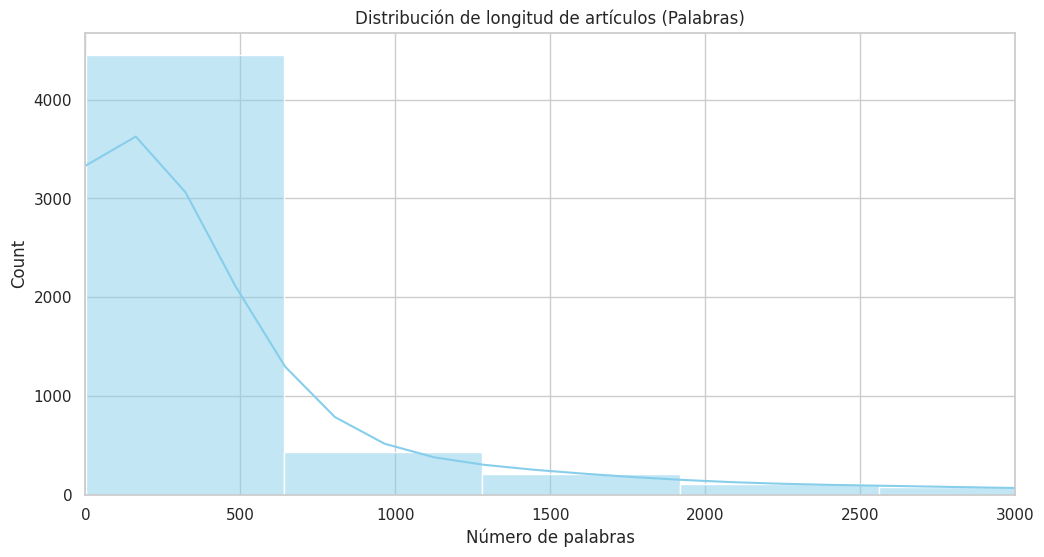

count     5483.000000
mean       589.414554
std       1569.883476
min          2.000000
25%         54.000000
50%        130.000000
75%        438.000000
max      31959.000000
Name: word_count, dtype: float64


In [6]:
# Calculamos la longitud aproximada en palabras
df['word_count'] = df['content'].apply(lambda x: len(x.split()))

# Histograma de longitud
plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color="skyblue")
plt.title("Distribución de longitud de artículos (Palabras)")
plt.xlabel("Número de palabras")
plt.xlim(0, 3000) # Limitamos visualmente para ver el grueso de datos
plt.show()

# Estadísticas clave
print(df['word_count'].describe())

In [7]:
import spacy

# Cargamos modelo ligero
nlp = spacy.load("en_core_web_sm")

def extract_sample_entities(text):
    doc = nlp(text[:1000]) # Solo analizamos el inicio para ser rápidos
    return [(ent.text, ent.label_) for ent in doc.ents]

# Tomamos un ejemplo aleatorio que tenga buen texto
sample_article = df[df['word_count'] > 200].sample(1).iloc[0]

print(f"🕵️ Analizando entidades en: {sample_article['title']}")
print("-" * 50)
entities = extract_sample_entities(sample_article['content'])

# Mostramos solo Personas (PERSON) y Grupos/Casas (ORG) y Lugares (GPE)
relevant_ents = [e for e in entities if e[1] in ['PERSON', 'ORG', 'GPE']]
print(relevant_ents[:15]) # Mostrar primeros 15 hallazgos

🕵️ Analizando entidades en: Florian Robin
--------------------------------------------------
[('Florian Robin', 'PERSON'), ('Thrones', 'ORG'), ('Richard Madden', 'PERSON'), ('Alfie Allen', 'PERSON'), ('House', 'ORG'), ('Dragon', 'ORG'), ('Kingdoms', 'GPE'), ('Thrones', 'ORG'), ('House', 'ORG')]
